In [ ]:
# Installing Python libraries
!pip install pymongo==3.7.2 folium==0.9.1 geopandas==0.7.0 seaborn numpy tqdm

In [1]:
import pymongo                            # Library to access MongoDB
from pymongo import MongoClient           # Imports MongoClient 
import pandas as pd                       # Library to work with dataframes
import folium                             # Library to create the map
from folium import plugins                # plugin to create a heatmap
import seaborn as sns
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [2]:
# uri (uniform resource identifier) defines the connection parameters 
uri = 'mongodb://127.0.0.1:27017'
# start client to connect to MongoDB server 
client = MongoClient( uri )
db = client.JiraRepos

In [3]:
def issue_map():
    """Get the custom issue mapping as a dictionary.
    """
    return dict(pd.read_csv('issue_map.csv').values)

# Cache as global variable here.
issue_dict = issue_map()
def standardize_issue_name(name):
    """Try to standardize issue types so they can be shown in less columns.
    """
    name = name.strip()
    return issue_dict[name] if name in issue_dict else name

def lexicon_to_array():
    lexicon = pd.read_csv('Harassment Lexicon.csv')
    return lexicon.astype(str).values.flatten().tolist()

def lexicon_to_regex():
    """Restricted to first 5 items since running it is very slow.
    """
    return "/" + "|".join(lexicon_to_array()[:5]) + "/"

def lexicon_to_space_delimited():
    return " ".join(lexicon_to_array())

def find_all_issue_types():
    """Find all issue types so we can run multiple queries that may run different subsets, allowing for setting 0's.
    """
    all_issue_types = set()
    collections = db.list_collection_names()[:7]
    
    progress_bar = tqdm(collections)
    for name in progress_bar:
        all_issue_types.update(set([standardize_issue_name(row["_id"]) for row in query_count_by_issue_type_without_sum(db[name])]))
    return all_issue_types

def query_count_by_issue_type(collection):
    return query_aggregate([
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_without_sum(collection):
    return query_aggregate([
        { "$group": { "_id": '$fields.issuetype.name'} },
    ], collection)

def query_count_by_issue_type_having_comments(collection):
     return query_aggregate([
        { "$match": { "fields.comments": { "$exists": "true", "$type": "array", "$ne": [] } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_having_toxic_comments(collection):
    """ (DONT USE THIS) This solution uses a regex and is very slow (also the format is fucked up due to the projection).
    """
    return query_aggregate([
        { "$project": {
            "fields.comments": {
                "$filter": {
                    "input": "$fields.comments.body",
                    "as": "varcommentbody",
                    "cond": { "$regexMatch": { "input": "$$varcommentbody", "regex": lexicon_to_regex(), "options": "i" } },
                }
            }
        } },
        { "$match": { "fields.comments": { "$exists": "true", "$type": "array", "$ne": [] } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_having_toxic_comments_fts(collection):
    """Uses a full-text search.
    """
    # Create index for specific column. A collection can only have 1 text index and it is automatically the one used.
    collection.create_index([('fields.comments.body', pymongo.TEXT)], name='my_search_index', default_language='english')
    return query_aggregate([
        { "$match": { "$text": { "$search": lexicon_to_space_delimited() } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)


def query_aggregate(query, collection):
    """ Convenience wrapper to track time.
    """
    start = time.time()
    result = list(collection.aggregate(query))
    end = time.time()
    # print("Duration: {} seconds".format(end - start))
    return result

In [4]:
def find_comments_per_issue(query_fn_string, issue_types):
    """This function runs a count query per issue type on each collection in our Jira database. It might take a minute or so.
    
    TODO: filter comments by toxic words (hopefully i can just edit the mongodb query to accept a list)
    
    """
    data = []
    
    collections = db.list_collection_names()
    # collections = np.array(db.list_collection_names())[:2]
    
    progress_bar = tqdm(collections)
    for name in progress_bar:
        progress_bar.set_description("Processing %s" % name)
        # Call function from string.
        result = globals()[query_fn_string](db[name])
        subdata = {};
        # Add any issue types with count data to the subdata.
        for row in result:
            issue_type = standardize_issue_name(row['_id'])
            if issue_type in subdata:
                subdata[issue_type] += row['count']
            else:
                subdata[issue_type] = row['count']
        data.append([name, subdata])
            
    # Fill in the complete matrix because issue types differ per subset.
    data2 = []
    for row in data:
        # First column = name
        subdata = [row[0]]
        for issue_type in issue_types:
            subdata.append(row[1][issue_type] if issue_type in row[1] else 0)
        data2.append(subdata)

    data2 = np.array(data2)
    # # Use first column as index, rest as the data.
    df = pd.DataFrame(np.array(data2[:,1:], dtype=np.int32), columns=list(issue_types), index=data2[:,0])   
    return df

In [5]:
all_issue_types = find_all_issue_types()
print(all_issue_types)
df_comments = find_comments_per_issue("query_count_by_issue_type_having_comments", all_issue_types)
df_toxic_comments = find_comments_per_issue("query_count_by_issue_type_having_toxic_comments_fts", all_issue_types)
print('Done')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:11<00:00,  1.68s/it]


{'research', 'support', 'task', 'improvement', 'feature', 'request', 'miscellaneous', 'bug', 'development', 'new', 'problem', 'documentation'}


Processing Jira: 100%|█████████████████████████████████████████████████████████████████| 16/16 [01:38<00:00,  6.16s/it]

Done


In [6]:
print(df_comments.shape)
print(df_toxic_comments.shape)

# Divide toxic comments by total comments to get a percentage.
df_div = df_toxic_comments.div(df_comments).fillna(0)

display(df_comments)
display(df_toxic_comments)
display(df_div)

(16, 12)
(16, 12)


,research,support,task,improvement,feature,request,miscellaneous,bug,development,new,problem,documentation
SecondLife,295,0,231,0,0,0,0,241,0,44,948,0
IntelDAOS,3815,0,195,0,0,0,0,3278,0,0,0,0
Mojang,0,0,0,0,0,0,0,381027,0,0,0,0
MariaDB,0,0,0,0,0,0,0,0,0,0,0,0
Hyperledger,3609,0,6861,520,0,0,0,5970,0,596,0,333
Sonatype,167,9371,1032,1973,0,0,0,5489,0,65470,1594,0
Sakai,1,0,8250,2,3,5049,1080,29521,58,0,0,0
Qt,2367,11083,11319,6,0,141,0,86955,0,0,0,0
JFrog,3,14,331,940,0,11,0,3482,0,665,0,5
Spring,1532,180,9185,18763,0,0,0,24959,0,6294,269,0


,research,support,task,improvement,feature,request,miscellaneous,bug,development,new,problem,documentation
SecondLife,132,0,46,0,0,0,0,71,0,11,337,0
IntelDAOS,953,0,57,0,0,0,0,1583,0,0,0,0
Mojang,0,0,0,0,0,0,0,166178,0,0,0,0
MariaDB,0,0,0,0,0,0,0,0,0,0,0,0
Hyperledger,607,0,824,32,0,0,0,1462,0,94,0,59
Sonatype,39,1342,106,372,0,0,0,1262,0,13845,332,0
Sakai,0,0,1995,0,0,1322,389,8043,17,0,0,0
Qt,508,2799,1774,2,0,24,0,25771,0,0,0,0
JFrog,1,4,39,145,0,5,0,806,0,125,0,1
Spring,200,31,681,3397,0,0,0,5941,0,1336,47,0


,research,support,task,improvement,feature,request,miscellaneous,bug,development,new,problem,documentation
SecondLife,0.447458,0.000000,0.199134,0.000000,0.00000,0.000000,0.000000,0.294606,0.000000,0.250000,0.355485,0.000000
IntelDAOS,0.249803,0.000000,0.292308,0.000000,0.00000,0.000000,0.000000,0.482916,0.000000,0.000000,0.000000,0.000000
Mojang,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.436132,0.000000,0.000000,0.000000,0.000000
MariaDB,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hyperledger,0.168191,0.000000,0.120099,0.061538,0.00000,0.000000,0.000000,0.244891,0.000000,0.157718,0.000000,0.177177
Sonatype,0.233533,0.143208,0.102713,0.188545,0.00000,0.000000,0.000000,0.229914,0.000000,0.211471,0.208281,0.000000
Sakai,0.000000,0.000000,0.241818,0.000000,0.00000,0.261834,0.360185,0.272450,0.293103,0.000000,0.000000,0.000000
Qt,0.214618,0.252549,0.156728,0.333333,0.00000,0.170213,0.000000,0.296372,0.000000,0.000000,0.000000,0.000000
JFrog,0.333333,0.285714,0.117825,0.154255,0.00000,0.454545,0.000000,0.231476,0.000000,0.187970,0.000000,0.200000
Spring,0.130548,0.172222,0.074143,0.181048,0.00000,0.000000,0.000000,0.238030,0.000000,0.212266,0.174721,0.000000


In [7]:
def draw_heatmap(data, title, xlabel, ylabel, fmt='d'):
    ax = plt.axes()
    sns.heatmap(data, annot=True, square=True, fmt=fmt)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    pass

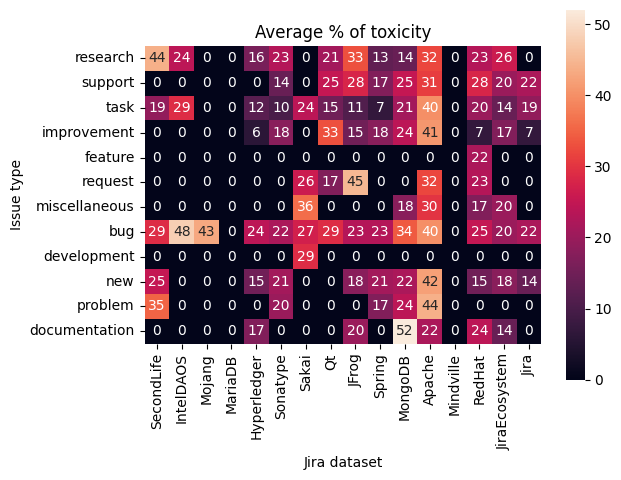

In [8]:
draw_heatmap(df_div.multiply(100).astype(int).T, 'Average % of toxicity', 'Jira dataset', 'Issue type')

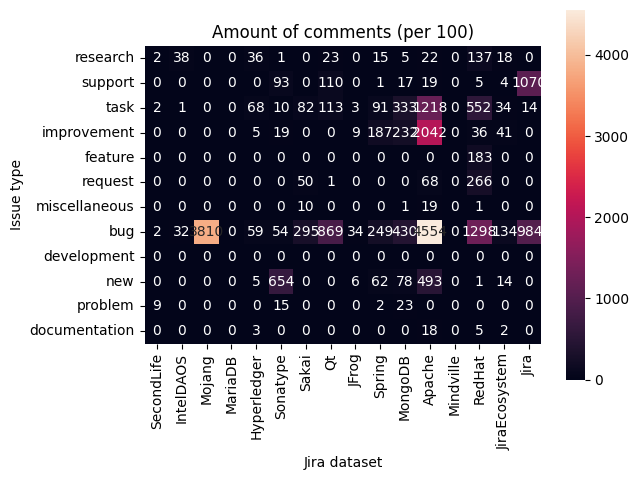

In [9]:
draw_heatmap(df_comments.divide(100).astype(int).T, 'Amount of comments (per 100)', 'Jira dataset', 'Issue type')

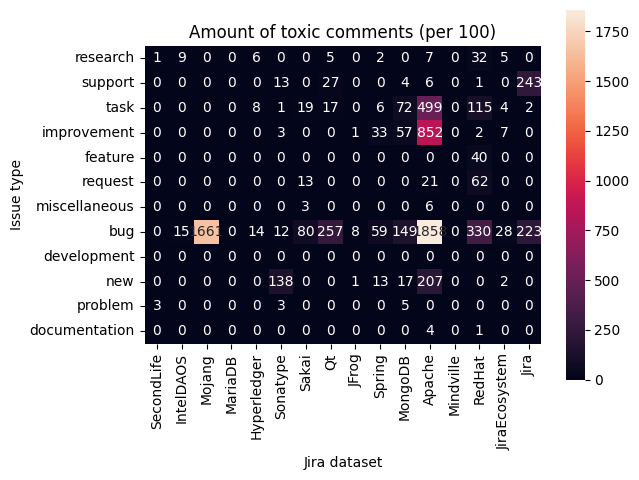

In [10]:
draw_heatmap(df_toxic_comments.divide(100).astype(int).T, 'Amount of toxic comments (per 100)', 'Jira dataset', 'Issue type')